In [23]:
from pyrocko import io,model,trace
import os
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# data folder (response removed)
workdir='../'
datadir =  os.path.join(workdir,'DATA_VLP')

# events catalogue
catdir=os.path.join(workdir,'CAT')
catname=os.path.join(catdir,'catalogue_flegrei_VLP_gilberto.pf')
target_events=model.load_events(catname)

# stations list
stationsdir=os.path.join(workdir,'META_DATA')
stationsname=os.path.join(stationsdir,'stations_flegrei_INGV_final_similarity.pf')
stations=model.load_stations(stationsname)

# figure dir
plotdir=os.path.join(workdir,'PLOTS/PAPER/SF2')

freq_min=0.09
freq_max=0.13

#dictionary for selected traces at selected stations
dict_traces = {key.station: [] for key in stations}
for station in dict_traces:
    dict_traces[station] = {key.name: [] for key in target_events}

#dictionary containing max amplitude registered at CPOZ for each event
dict_cpoz_max = {key.name: [] for key in target_events}

for targ_ev in target_events:   # loop each event
    event_name=targ_ev.name
    ev_dir = os.path.join(datadir, event_name)
    
    if not os.path.isdir(ev_dir):
        print(event_name, 'missing data dir', ev_dir)
    elif os.path.isdir(ev_dir):
        file_name = os.path.join(ev_dir,event_name + '.mseed' )
        traces = io.load(file_name)
        print(f'reading event: {event_name}')

        for tr in traces:   # normalize traces for each event relative to CPOZ
            if tr.channel=='HHZ' and tr.station=='CPOZ':
                tmp_trace_max= tr.copy()
                tmp_trace_max.lowpass(4,freq_max)
                tmp_trace_max.highpass(4,freq_min)
                tmp_trace_max.chop(tmp_trace_max.tmin+240, tmp_trace_max.tmax-120)
                max_cpoz=np.max(np.abs(tmp_trace_max.ydata) )
                dict_cpoz_max[event_name]=max_cpoz

        for tr in traces:
            if tr.channel=='HHZ':   # select HHZ channel
                for key in dict_traces:
                    if key== tr.station:    #  if target station is = to trace station
                        tmp_trace= tr
                        tmp_trace.lowpass(4,freq_max)
                        tmp_trace.highpass(4,freq_min)
                        tmp_trace.chop(tmp_trace.tmin+240, tmp_trace.tmax-120)
                        tmp_trace.ydata /= max_cpoz
                        dict_traces[tr.station][event_name].append(tmp_trace)

reading event: flegrei_2018_09_18_21_36_41
reading event: flegrei_2023_06_11_06_44_25
reading event: flegrei_2023_09_07_17_45_28
reading event: flegrei_2023_09_26_07_10_29
reading event: flegrei_2023_10_02_20_08_26
reading event: flegrei_2024_04_27_03_44_56
reading event: flegrei_2024_05_22_06_28_00
reading event: flegrei_2024_06_08_01_52_04
reading event: flegrei_2024_06_18_01_58_24
reading event: flegrei_2024_07_26_11_46_21
reading event: flegrei_2024_08_30_19_23_15
reading event: flegrei_2025_02_16_14_30_02


In [25]:
st_corr='CPOZ'
print(f'time shift at station {st_corr}')
for ev in dict_traces[st_corr]:
    if dict_traces[st_corr][ev] != []:
        tmp_corr=trace.correlate(dict_traces[st_corr]['flegrei_2024_04_27_03_44_56'][0],dict_traces[st_corr][ev][0])
    t, coef = tmp_corr.max()  # get time and value of maximum
    print(f'{ev} t : {t:9.5}')

time shift at station CPOZ
flegrei_2018_09_18_21_36_41 t : -1.7688e+08
flegrei_2023_06_11_06_44_25 t : -2.7724e+07
flegrei_2023_09_07_17_45_28 t : -2.0081e+07
flegrei_2023_09_26_07_10_29 t : -1.8477e+07
flegrei_2023_10_02_20_08_26 t : -1.7912e+07
flegrei_2024_04_27_03_44_56 t :       0.0
flegrei_2024_05_22_06_28_00 t : 2.1698e+06
flegrei_2024_06_08_01_52_04 t : 3.622e+06
flegrei_2024_06_18_01_58_24 t : 4.4864e+06
flegrei_2024_07_26_11_46_21 t : 7.8049e+06
flegrei_2024_08_30_19_23_15 t : 1.0856e+07
flegrei_2025_02_16_14_30_02 t : 2.5527e+07


In [26]:
for ev in dict_traces['CPOZ']:
    tmp_corr=trace.correlate(dict_traces['CPOZ']['flegrei_2024_04_27_03_44_56'][0],dict_traces['CPOZ'][ev][0])
    t, coef = tmp_corr.max()  # get time and value of maximum
    print(t)

    for station in dict_traces:
        if dict_traces[station][ev] != []:
            dict_traces[station][ev][0].shift(-t)        # align b with a
            if t<0:
                dict_traces[station][ev][0].ydata *= -1


-176882894.3499999
-27723630.569999933
-20080767.50999999
-18477266.700000048
-17912189.599999905
0.0
2169784.0900001526
3622028.539999962
4486408.120000124
7804884.829999924
10856299.549999952
25526706.340000153


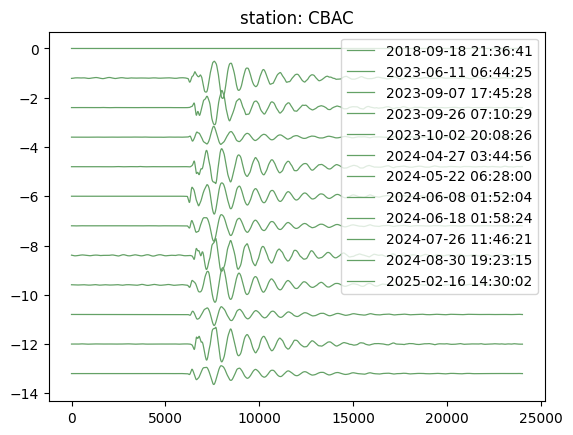

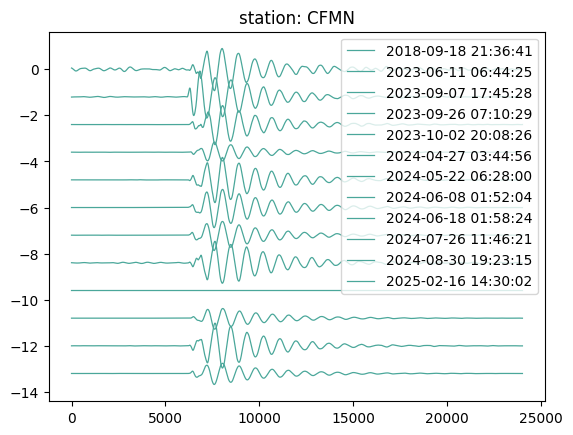

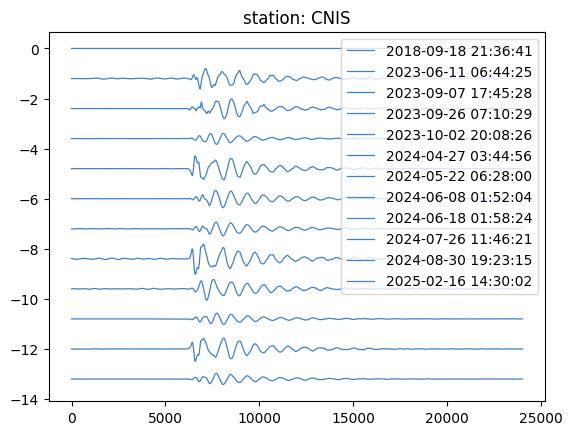

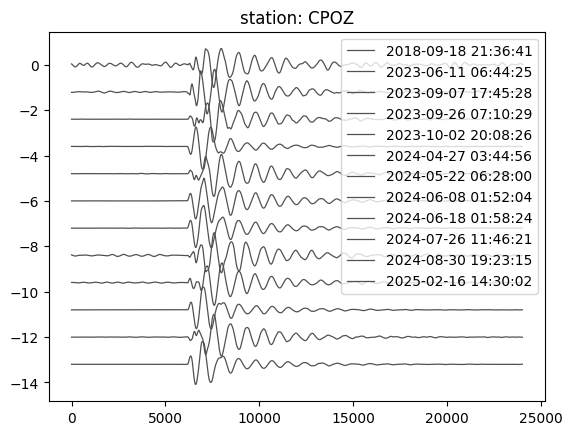

In [28]:
colors = {key.station: [] for key in stations}
colors['CBAC']='#64A166'
colors['CPOZ']='#515151'
colors['CNIS']='#4481BD'
colors['CFMN']='#4AA79A'

zero_trace=np.zeros(len(tmp_trace.ydata))

for station in dict_traces:
    y_shift=0
    plt.figure(f'{station}')
    plt.title(f'station: {station}')
    for ev in dict_traces[station]:
            tr_label=f'{ev[8:12]}-{ev[13:15]}-{ev[16:18]} {ev[19:21]}:{ev[22:24]}:{ev[25:]}'
            try:
                trace=dict_traces[station][ev][0].ydata      
                plt.plot(trace - y_shift,label=tr_label,color=colors[station],linewidth=0.9)
                y_shift+=1.2
            except:
                plt.plot(zero_trace - y_shift,label=tr_label,color=colors[station],linewidth=0.9)
                y_shift+=1.2
    plt.legend(loc=1)
    #plt.savefig(plotdir+f'/{station}_similarity.pdf')